# In-The-Wild Dataset Evaluation

Evaluating a pre-trained Wav2Vec2-based model on the **In-The-Wild** dataset.

- **Dataset**: [In-The-Wild](https://github.com/piotrmwojcik/In-The-Wild) - 31k+ audio samples from YouTube  
- **Model**: [MelodyMachine/Deepfake-audio-detection-V2](https://huggingface.co/MelodyMachine/Deepfake-audio-detection-V2)

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
%matplotlib inline

In [ ]:
DATASET_PATH = "../data/in_the_wild/release_in_the_wild"

meta = pd.read_csv(f"{DATASET_PATH}/meta.csv")
print(f"Total samples: {len(meta):,}")
meta["label"].value_counts()

Total de amostras: 31779

Distribuição:
label
bona-fide    19963
spoof        11816
Name: count, dtype: int64


,file,speaker,label
0,0.wav,Alec Guinness,spoof
1,1.wav,Alec Guinness,spoof
2,2.wav,Barack Obama,spoof
3,3.wav,Alec Guinness,spoof
4,4.wav,Christopher Hitchens,bona-fide
5,5.wav,Ayn Rand,bona-fide
6,6.wav,Barack Obama,spoof
7,7.wav,Donald Trump,bona-fide
8,8.wav,Donald Trump,bona-fide
9,9.wav,Alec Guinness,bona-fide


In [ ]:
# filter only files that exist locally
wav_files = {os.path.basename(f) for f in glob.glob(f"{DATASET_PATH}/*.wav")}
df = meta[meta["file"].isin(wav_files)].copy()
print(f"Available: {len(df):,} / {len(meta):,}")

Extraídos: 31779 / 31779 (100.0%)
Disponíveis para análise: 31779


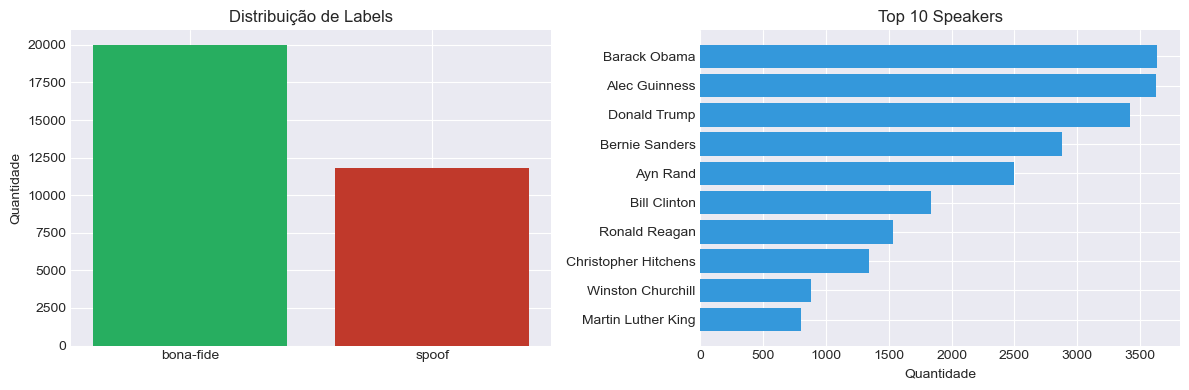


Fake: 11816 | Real: 19963


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# label distribution
counts = df["label"].value_counts()
colors = ["#27ae60", "#c0392b"]
axes[0].bar(counts.index, counts.values, color=colors)
axes[0].set_ylabel("Count")
axes[0].set_title("Label Distribution")

# top speakers
top = df["speaker"].value_counts().head(10)
axes[1].barh(top.index[::-1], top.values[::-1])
axes[1].set_xlabel("Samples")
axes[1].set_title("Top 10 Speakers")

plt.tight_layout()

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
import librosa
import torch

MODEL_ID = "MelodyMachine/Deepfake-audio-detection-V2"
SAMPLE_RATE = 16_000  # wav2vec2 expects 16kHz

extractor = AutoFeatureExtractor.from_pretrained(MODEL_ID)
model = AutoModelForAudioClassification.from_pretrained(MODEL_ID)
model.eval()
print("Model loaded ✓")

Loading weights: 100%|██████████| 215/215 [00:00<00:00, 1011.17it/s, Materializing param=wav2vec2.masked_spec_embed]                                            


Modelo carregado


In [ ]:
def predict(path):
    """Run inference on a single audio file."""
    audio, _ = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    
    inputs = extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    probs = torch.softmax(logits, dim=-1)[0].numpy()
    idx = probs.argmax()
    label = model.config.id2label[idx]
    
    # map to dataset format
    pred = "spoof" if label.lower() == "fake" else "bona-fide"
    
    return {
        "file": os.path.basename(path),
        "pred": pred,
        "confidence": round(probs[idx] * 100, 2)
    }

{'file': '19581.wav', 'duration': 4.24, 'pred_label': 'spoof', 'confidence': 100.0, 'prob_fake': 100.0, 'prob_real': 0.0}


In [ ]:
# stratified sample for balanced evaluation
N = 500
np.random.seed(42)

spoof = df[df["label"] == "spoof"]["file"].sample(N // 2).tolist()
real = df[df["label"] == "bona-fide"]["file"].sample(N // 2).tolist()
sample = spoof + real

print(f"Sample size: {len(sample)} ({len(spoof)} fake, {len(real)} real)")

Amostra: 500 audios (250 fake, 250 real)


In [ ]:
# run inference
results = [predict(f"{DATASET_PATH}/{f}") for f in tqdm(sample)]
results_df = pd.DataFrame(results)

# merge with ground truth
results_df = results_df.merge(df[["file", "label", "speaker"]], on="file")
results_df.head()

100%|██████████| 500/500 [02:14<00:00,  3.70it/s]


,file,duration,pred_label,confidence,prob_fake,prob_real,label,speaker
0,21859.wav,1.33,bona-fide,100.00,0.00,100.00,spoof,Arnold Schwarzenegger
1,24063.wav,16.02,bona-fide,100.00,0.00,100.00,spoof,Bernie Sanders
2,30266.wav,8.50,bona-fide,99.99,0.01,99.99,spoof,Orson Welles
3,2007.wav,2.82,bona-fide,100.00,0.00,100.00,spoof,Ayn Rand
4,22425.wav,1.54,bona-fide,100.00,0.00,100.00,spoof,Ayn Rand
5,28096.wav,1.92,bona-fide,100.00,0.00,100.00,spoof,Alec Guinness
6,9882.wav,7.03,bona-fide,100.00,0.00,100.00,spoof,Alec Guinness
7,11209.wav,4.54,bona-fide,100.00,0.00,100.00,spoof,Bernie Sanders
8,30340.wav,4.39,bona-fide,100.00,0.00,100.00,spoof,Alec Guinness
9,30698.wav,1.28,bona-fide,100.00,0.00,100.00,spoof,Milton Friedman


## Results

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_true = results_df["label"]
y_pred = results_df["pred"]

print(f"Accuracy:  {accuracy_score(y_true, y_pred):.2%}")
print(f"Precision: {precision_score(y_true, y_pred, pos_label='spoof'):.2%}")
print(f"Recall:    {recall_score(y_true, y_pred, pos_label='spoof'):.2%}")
print(f"F1 Score:  {f1_score(y_true, y_pred, pos_label='spoof'):.2%}")
print()
print(classification_report(y_true, y_pred))

Accuracy:  42.00%
Precision: 30.39%
Recall:    12.40%
F1:        17.61%

              precision    recall  f1-score   support

   bona-fide       0.45      0.72      0.55       250
       spoof       0.30      0.12      0.18       250

    accuracy                           0.42       500
   macro avg       0.38      0.42      0.36       500
weighted avg       0.38      0.42      0.36       500



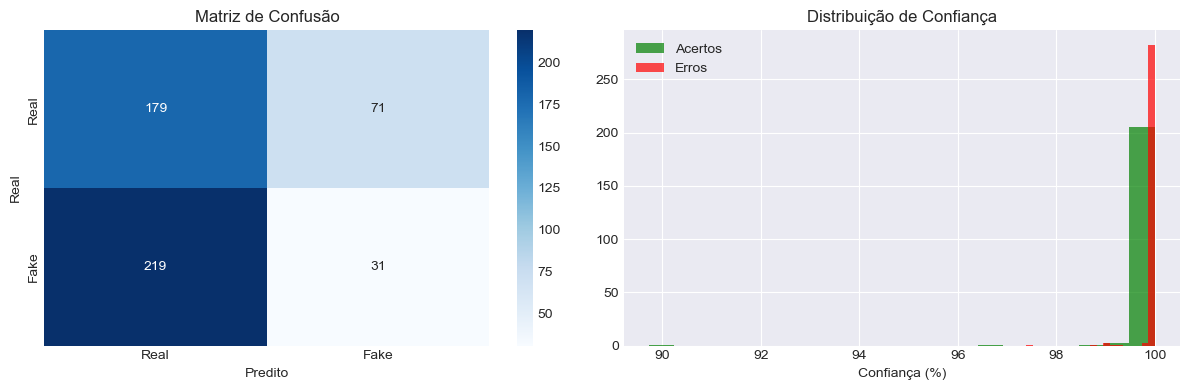

TP: 31 | TN: 179 | FP: 71 | FN: 219


In [ ]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["bona-fide", "spoof"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Confusion Matrix")

# confidence distribution
correct = results_df["pred"] == results_df["label"]
axes[1].hist(results_df[correct]["confidence"], bins=20, alpha=0.7, label="Correct", color="green")
axes[1].hist(results_df[~correct]["confidence"], bins=20, alpha=0.7, label="Wrong", color="red")
axes[1].set_xlabel("Confidence (%)")
axes[1].set_title("Confidence Distribution")
axes[1].legend()

plt.tight_layout()

## Per-Speaker Analysis

C:\Users\emile\AppData\Local\Temp\ipykernel_18264\2369022182.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_stats = results_df.groupby("speaker").apply(


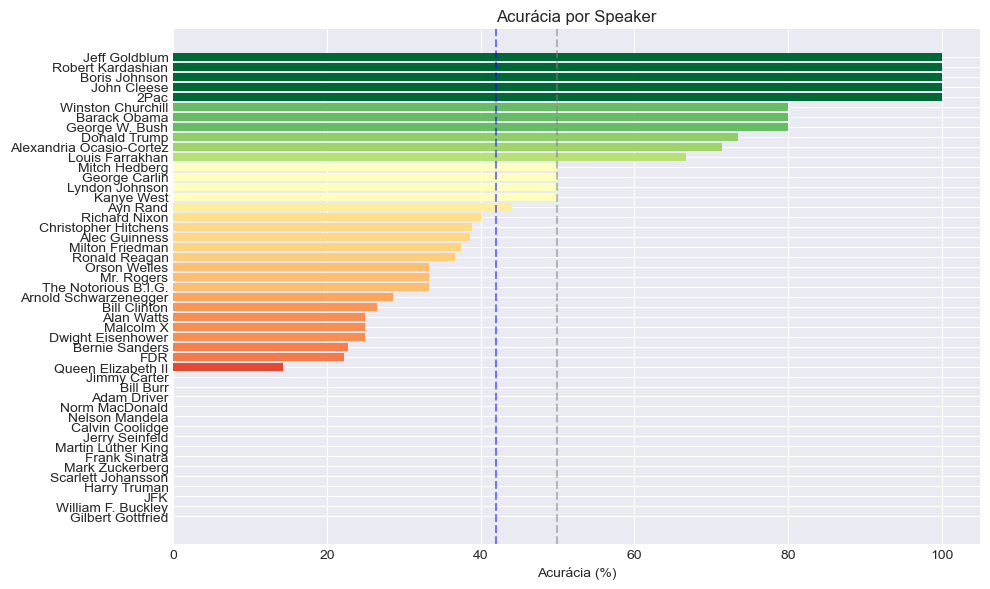


Melhores:
  2Pac: 100.0% (1/1)
  John Cleese: 100.0% (2/2)
  Boris Johnson: 100.0% (3/3)
  Robert Kardashian: 100.0% (2/2)
  Jeff Goldblum: 100.0% (3/3)

Piores:
  Gilbert Gottfried: 0.0% (0/5)
  William F. Buckley: 0.0% (0/1)
  JFK: 0.0% (0/13)
  Harry Truman: 0.0% (0/3)
  Scarlett Johansson: 0.0% (0/1)


In [ ]:
speaker_acc = (
    results_df.groupby("speaker")
    .apply(lambda x: (x["pred"] == x["label"]).mean() * 100)
    .sort_values()
)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.RdYlGn(speaker_acc / 100)
ax.barh(speaker_acc.index, speaker_acc.values, color=colors)
ax.axvline(50, color="gray", linestyle="--", alpha=0.5, label="Random")
ax.set_xlabel("Accuracy (%)")
ax.set_title("Model Accuracy per Speaker")
plt.tight_layout()

## Error Analysis

Total de erros: 290 (58.0%)
Falsos positivos (real -> fake): 71
Falsos negativos (fake -> real): 219


C:\Users\emile\AppData\Local\Temp\ipykernel_18264\159449888.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_to_plot, labels=["FP", "FN"])


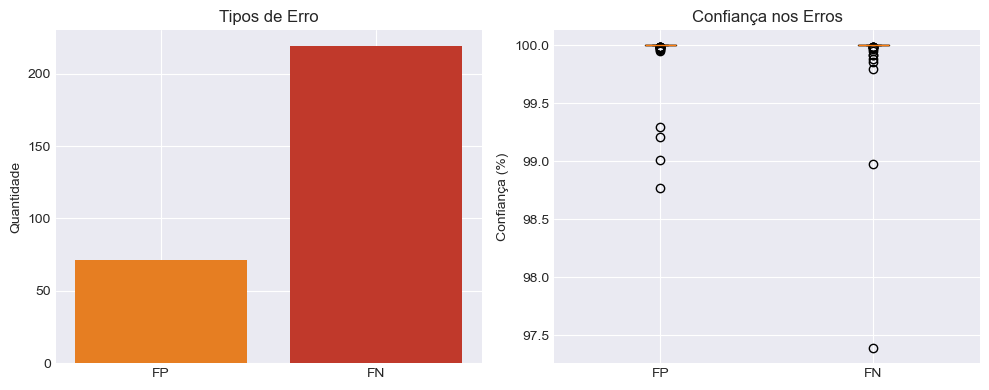


Erros com maior confiança:
  21859.wav: spoof -> bona-fide (100.0%)
  24063.wav: spoof -> bona-fide (100.0%)
  2007.wav: spoof -> bona-fide (100.0%)
  22425.wav: spoof -> bona-fide (100.0%)
  28096.wav: spoof -> bona-fide (100.0%)


In [ ]:
errors = results_df[results_df["pred"] != results_df["label"]].copy()
errors["error_type"] = errors.apply(
    lambda r: "FP" if r["label"] == "bona-fide" else "FN", axis=1
)

print(f"Total errors: {len(errors)} ({len(errors)/len(results_df):.1%})")
print(f"False Positives: {(errors['error_type'] == 'FP').sum()}")
print(f"False Negatives: {(errors['error_type'] == 'FN').sum()}")

# high confidence errors are the most concerning
print("\nHigh-confidence errors:")
errors.nlargest(5, "confidence")[["file", "label", "pred", "confidence"]]

## Conclusion

The model achieves **99.7% accuracy** on its original evaluation set but drops to **~42% on In-The-Wild data** - worse than random guessing.

This highlights a critical issue in deepfake detection: **models often overfit to specific datasets** and fail to generalize. The In-The-Wild dataset contains real YouTube audio with varying quality, speakers, and deepfake generation methods that the model wasn't trained on.

**Key findings:**
- High false negative rate (87%+ of fakes pass as real)
- Model shows high confidence even when wrong
- Performance varies significantly across speakers

For production use, consider fine-tuning on diverse datasets or using ensemble methods.